In [1]:
!pip install PyStasm

Traceback (most recent call last):
  File "/usr/bin/pip", line 9, in <module>
    from pip import main
ImportError: cannot import name main


In [2]:
import os.path
import cv2
import stasm
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve

## Config

In [3]:
# from google.colab import drive
# drive.mount("/content/drive")
# IMAGES_PATH = "/content/drive/My Drive/images"
# GEN_IMAGES_PATH = '/content/drive/My Drive/generated_images/'

In [4]:
IMAGES_PATH = "/content/drive/My Drive/images"
GEN_IMAGES_PATH = '/content/drive/My Drive/generated_images/'

In [5]:
IMAGES_PATH = '../../images/'
GEN_IMAGES_PATH = '../../generated_images/'

## Step 1 : Using PyStasm to generate landmarks in reference and target image

In [6]:
ref = cv2.imread(os.path.join(IMAGES_PATH, 'ref.png'))
ref_color = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)

In [7]:
target = cv2.imread(os.path.join(IMAGES_PATH, 'target.png'))
target_color = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'Target Image')

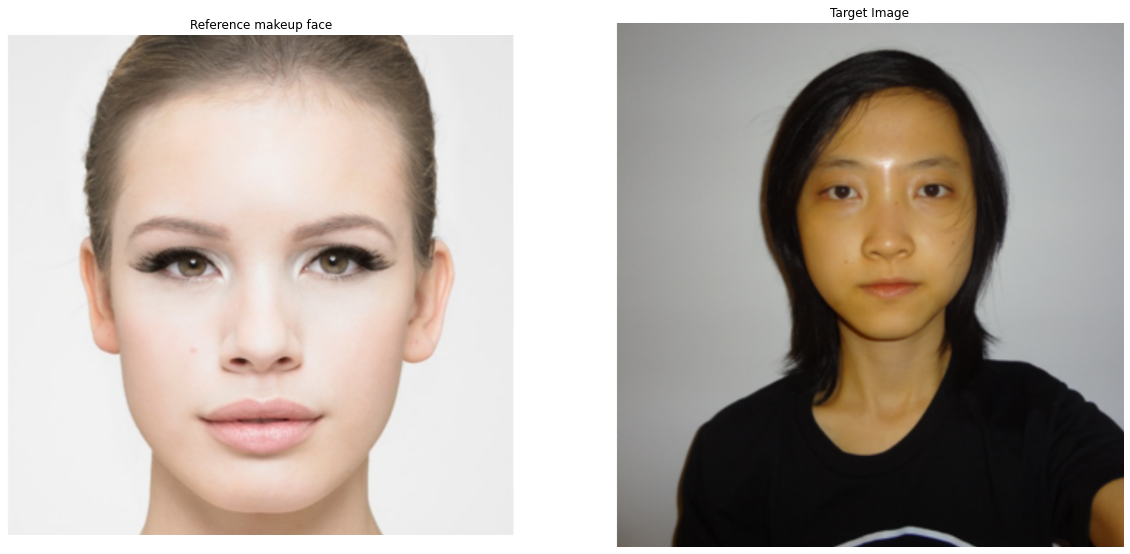

In [8]:
fig = plt.figure(figsize = (20, 10))

fig.add_subplot(1, 2, 1)
plt.imshow(ref_color)
plt.axis('off')
plt.title("Reference makeup face")

fig.add_subplot(1, 2, 2)
plt.imshow(target_color)
plt.axis('off')
plt.title("Target Image")



In [9]:
ref_gray = cv2.cvtColor(ref_color, cv2.COLOR_RGB2GRAY)
target_gray = cv2.cvtColor(target_color, cv2.COLOR_RGB2GRAY)

In [10]:
ref_landmarks = stasm.search_single(ref_gray)
target_landmarks = stasm.search_single(target_gray)

ref_l = stasm.force_points_into_image(ref_landmarks, ref_gray)
target_l = stasm.force_points_into_image(target_landmarks, target_gray)

points1 = list(map(tuple,ref_l))
points2 = list(map(tuple, target_l))

In [11]:
## Making landmark points white
ref_copy = ref_color.copy()
target_copy = target_color.copy()

black = (0,0,0)
for x, y in ref_l:
    ref_copy = cv2.circle(ref_copy, (round(x), round(y)), 2, black, 1)
    
white = (255,255,255)
for x, y in target_l:
    target_copy = cv2.circle(target_copy, (round(x), round(y)), 1, white, 1)

Text(0.5, 1.0, 'Target Landmarks')

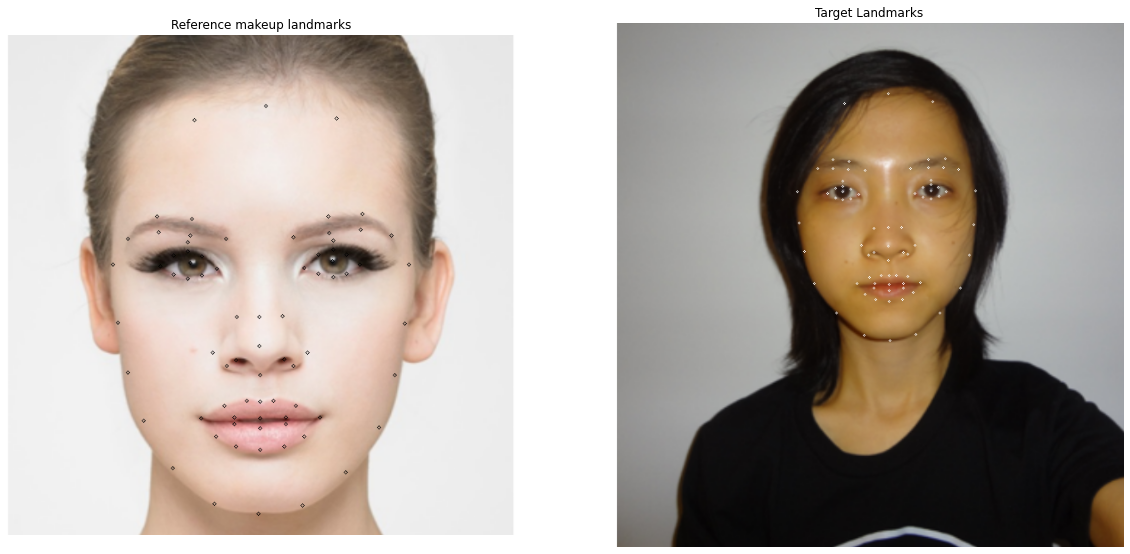

In [12]:
fig = plt.figure(figsize = (20, 10))

fig.add_subplot(1, 2, 1)
plt.imshow(ref_copy)
plt.axis('off')
plt.title("Reference makeup landmarks")

fig.add_subplot(1, 2, 2)
plt.imshow(target_copy)
plt.axis('off')
plt.title("Target Landmarks")

### Saving images 

In [13]:
cv2.imwrite(os.path.join(GEN_IMAGES_PATH, 'ref_dotted.png'),cv2.cvtColor(ref_copy, cv2.COLOR_BGR2RGB))
cv2.imwrite(os.path.join(GEN_IMAGES_PATH, 'target_dotted.png'),cv2.cvtColor(target_copy, cv2.COLOR_BGR2RGB))

True

## Step 2 : Thin plate splice warping

#### tpsMap

In [14]:
def tpsMap(wW, imgH, imgW, xp, yp, NPs):
    X, Y = np.meshgrid(np.arange(1, imgH + 1), np.arange(1, imgW + 1))
    X = X.T.flatten().reshape(1, -1)
    Y = Y.T.flatten().reshape(1, -1)
    _, NWs = X.shape
    
    rx = np.repeat(X, NPs, axis = 0)
    ry = np.repeat(Y, NPs, axis = 0)
    
    assert rx.shape == (NPs, NWs), "Shape of rx is not right"
    assert ry.shape == (NPs, NWs), "Shape of ry is not right"

    rxP = np.repeat(xp.reshape(-1, 1), NWs, axis = 1)
    ryP = np.repeat(yp.reshape(-1, 1), NWs, axis = 1)
    
    assert rxP.shape == (NPs, NWs), "Shape of rxP is not right"
    assert ryP.shape == (NPs, NWs), "Shape of ryP is not right"
    
    wR = np.sqrt((rx - rxP)**2 + (ry - ryP)**2)
    wK = radial_basis(wR)
    assert wK.shape == (NPs, NWs)
    wP = np.hstack((np.ones((NWs, 1)), X.T, Y.T)).T
    
    wL = np.vstack((wK, wP)).T
    
    Xw = wL @ wW[:, 0]
    Yw = wL @ wW[:, 1]
    return Xw, Yw

#### Inverse distance weighted interpolation function

In [15]:
def compWk(map_h, cx, cy, p):
    h, w = map_h.shape
    x, y = np.meshgrid(np.arange(1,h + 1), np.arange(1, w + 1))
    y = (y - cy)**2
    x = (x - cx)**2
    d2 = x + y
    ans = 1 / (np.power(d2.T, p / 2))
    return ans

def idw(in_h, map_h, wk):
    num = np.sum(in_h[map_h != 0].astype(dtype=np.double) * wk[map_h != 0])
    den = np.sum(wk[map_h != 0])
    return num / den

def idwMvInterp(imgw, map_holes, maxhw, p):
    '''
    Fill holes using Inverse Distance weighted interpolation
    '''
    outH, outW, color = imgw.shape
    out = imgw.copy()
    yi_arr, xi_arr = np.where(map_holes == 0)
    assert xi_arr.size == yi_arr.size, "Normie check"
    
    yi_size = yi_arr.size

    if yi_size != 0:
        for ix in range(yi_size):
            
            xi = xi_arr[ix]
            yi = yi_arr[ix]
            yixL = max(yi - maxhw, 1)
            yixU = min(yi + maxhw, outH)
            xixL = max(xi - maxhw, 1)
            xixU = min(xi + maxhw, outW)
            
            mapw = map_holes[yixL - 1:yixU,xixL - 1:xixU]
            if np.where(mapw.flatten() == 1)[0].size != 0:
                wk = compWk(mapw, xi - xixL + 1, yi - yixL + 1, p)
                
                for colIx in range(color):
                    out[yi, xi, colIx] = idw(imgw[yixL - 1:yixU,xixL - 1:xixU, colIx], mapw, wk)
                    
    return out

### interp2d

In [16]:
def interp2d(X, Y, img, Xwr, Ywr, outH, outW, interp):
    '''
    Args:
    X, Y = meshgrid of input image
    img = input image
    Xwr, Ywr = warped meshgrid
    outH, outW = dimensions of the output image
    interp = dictionary {'radius','power'}
    '''
    imgH, imgW, color = img.shape
    imgwr = np.zeros((outH, outW, color))
    try:
        maxhw = (interp['radius'] - 1) // 2
    except KeyError:
        print("interp has no radius key")
    Xwi = np.round(Xwr).astype(dtype=np.int)
    Ywi = np.round(Ywr).astype(dtype=np.int)
    
    Xwi = np.maximum(np.minimum(Xwi, outH),1)
    Ywi = np.maximum(np.minimum(Ywi, outW),1)
    fiw = np.ravel_multi_index(np.array([Xwi - 1, Ywi - 1]),(outH, outW), order='F')
    fip = np.ravel_multi_index(np.array([X - 1, Y - 1]),(imgH, imgW), order='F')
    
    ## fip is right, expected 6.7647e10, got 67646327931
    ## fiw is right, expected 4.4145e10, got 44144174403
    

    for colIx in range(color):
        o_r = np.zeros((outH, outW))
        img_r = img[:,:,colIx]
        p = o_r.flatten()
        p[fiw] = img_r.flatten(order='C')[fip]
        o_r = p.reshape(o_r.shape, order = 'F')
        imgwr[:,:,colIx] =  o_r
        
    map_holes = np.zeros((outH, outW))
    t = map_holes.flatten()
    t[fiw] = 1
    map_holes = t.reshape(map_holes.shape, order = 'F')
    
    po = 2
    try:
        po = interp['power']
    except KeyError:
        print("interp has no power along with invdist interpolation function, defaulting to power = 2")
    imgw = idwMvInterp(imgwr, map_holes, maxhw, po)
    
    return imgw, imgwr, map_holes

### tpsWarp - main function

In [17]:
def radial_basis(mat):
    q = mat.copy()
    q[mat == 0] = 1e-3
    return 2 * mat**2 * np.log(q)

In [18]:
def compute_Wl(xp, yp, NP):
    xp = xp.reshape(-1, 1)
    yp = yp.reshape(-1, 1)
    rXp = np.repeat(xp, NP, axis = 1)
    rYp = np.repeat(yp, NP, axis = 1)
    
    wR = np.sqrt((rXp - rXp.T)**2 + (rYp - rYp.T)**2)
    wK = radial_basis(wR)
    wP = np.hstack((np.ones((NP, 1)), xp, yp))
    
    wL_topRow = np.hstack((wK, wP))
    wL_bottomRow = np.hstack((wP.T, np.zeros((3, 3))))
    wL = np.vstack((wL_topRow, wL_bottomRow))
    return wL

In [19]:
def tpswarp(img, outDim, Zp, Zs, interp):
    NPs,_ = Zp.shape
    imgH, imgW, _ = img.shape
    Xp = Zp[:, 0].T
    Yp = Zp[:, 1].T

    Xs = Zs[:, 0].T
    Ys = Zs[:, 1].T
    outH, outW, _ = outDim
    
    wL = compute_Wl(Xp, Yp, NPs)
    
    ## wL is right == 26867 * 10^9
    assert wL.shape == (NPs + 3, NPs + 3), "Output wL is of wrong shape"
    wY_top = np.hstack((Xs.reshape(-1, 1), Ys.reshape(-1, 1)))
    wY_bottom = np.zeros((3, 2))
    wY = np.vstack((wY_top, wY_bottom))
    
    ## wY is right == 41174
    assert wY.shape == (NPs + 3, 2)
    wW = np.linalg.inv(wL) @ wY
    
    ## wW is right == 155.1481
    assert wW.shape == (NPs + 3, 2)
    Xw, Yw = tpsMap(wW, imgH, imgW, Xp, Yp, NPs)
    
    ## Xw is right, expected 1.1105 * 1e8, got 111046639.14
    ## Yw is right, expected 7.5128 * 1e7, got 75127850.684
    
    x, y = np.meshgrid(np.arange(1,imgH + 1), np.arange(1,imgW + 1))
    imgw, imgwr, map_h = interp2d(x.flatten(), y.flatten(), img, Xw, Yw,outH, outW, interp)
    return imgw, imgwr, map_h

In [20]:
interp = {
    'radius' : 5,
    'power' : 2
}

In [21]:
a, b, c = tpswarp(ref_color, target_color.shape, np.flip(ref_l, 1), np.flip(target_l, 1), interp)

/home/shaunak/miniconda2/envs/dmt_new/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/shaunak/miniconda2/envs/dmt_new/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [22]:
a_disp = np.uint8(a)
b_disp = np.uint8(b)

Text(0.5, 1.0, 'Holes in the image')

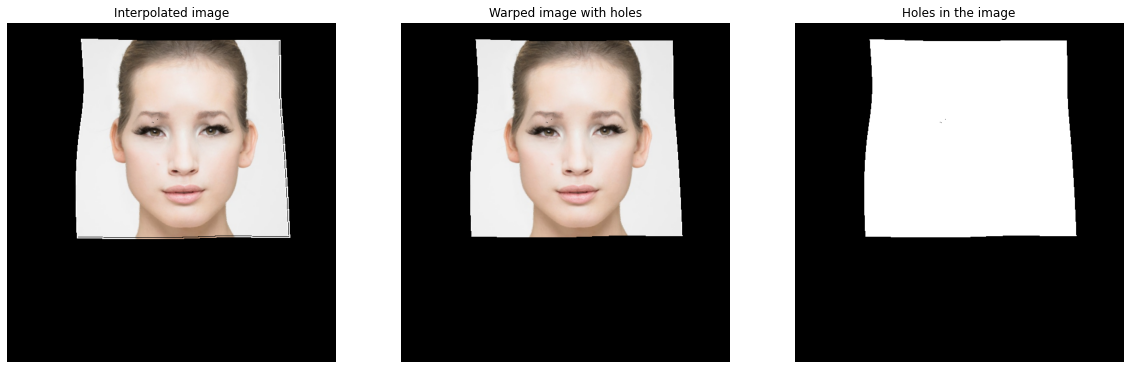

In [23]:
fig = plt.figure(figsize = (20, 60))

fig.add_subplot(1, 3, 1)
plt.imshow(a_disp)
plt.axis('off')
plt.title("Interpolated image")

fig.add_subplot(1, 3, 2)
plt.imshow(b_disp)
plt.axis('off')
plt.title("Warped image with holes")

fig.add_subplot(1, 3, 3)
plt.imshow(c, cmap="gray")
plt.axis('off')
plt.title("Holes in the image")

Text(0.5, 1.0, 'Images superimposed on each other')

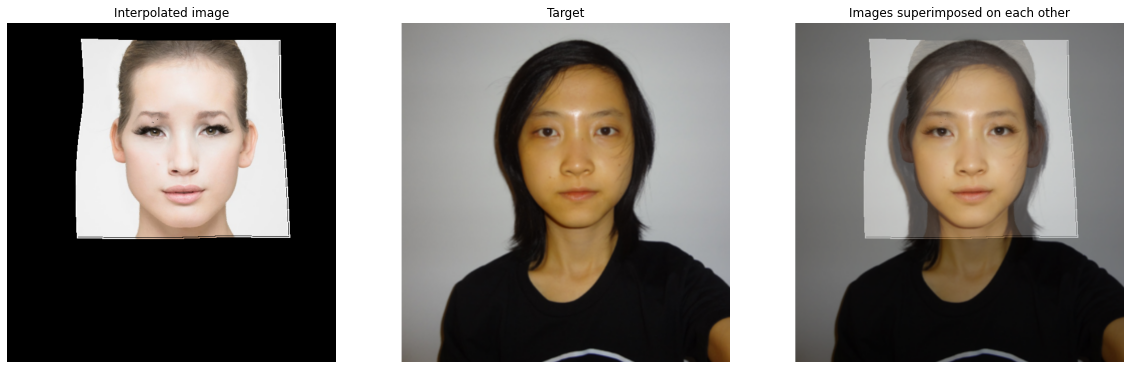

In [24]:
fig = plt.figure(figsize = (20, 60))

fig.add_subplot(1, 3, 1)
plt.imshow(a_disp)
plt.axis('off')
plt.title("Interpolated image")

fig.add_subplot(1, 3, 2)
plt.imshow(target_color)
plt.axis('off')
plt.title("Target")

super_imposed = np.floor(a_disp * 0.3 + target_color * 0.7).astype(dtype=np.uint8)
fig.add_subplot(1, 3, 3)
plt.imshow(super_imposed)
plt.axis('off')
plt.title("Images superimposed on each other")

### saving warped image

In [25]:
cv2.imwrite(os.path.join(GEN_IMAGES_PATH,'interpolated_image.png'), cv2.cvtColor(a_disp, cv2.COLOR_BGR2RGB))
cv2.imwrite(os.path.join(GEN_IMAGES_PATH,'superimposed_image.png'), cv2.cvtColor(super_imposed, cv2.COLOR_BGR2RGB))

True

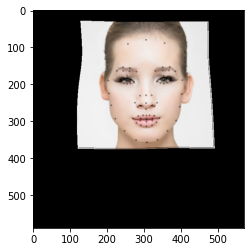

In [26]:
ref_interp_copy = a_disp.copy()

black = (0,0,0)
for x, y in target_l:
    ref_interp_copy = cv2.circle(ref_interp_copy, (round(x), round(y)), 2, black, 1)

plt.imshow(ref_interp_copy)

In [47]:
def visualize_facial_landmarks(image,points,alpha=1):
    overlay = image.copy()
    output = image.copy()

    hull1 = cv2.convexHull(np.array(points[30:38]))
    cv2.drawContours(overlay, [hull1.astype(int)], -1, (0,0,0), -1)

    hull2 = cv2.convexHull(np.array(points[40:48]))
    cv2.drawContours(overlay, [hull2.astype(int)], -1, (0,0,0), -1)

    hull3 = cv2.convexHull(np.array(points[59:77]))
    cv2.drawContours(overlay, [hull3.astype(int)], -1, (0,0,0), -1)

    cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

    return output

In [48]:
def eye_lip_extraction(img,points):
  img_b,img_g,img_r = cv2.split(img)
  
  output_r = visualize_facial_landmarks(img_r,points)
  output_g = visualize_facial_landmarks(img_g,points)
  output_b = visualize_facial_landmarks(img_b,points)

  output = cv2.merge((output_r,output_g,output_b))
  return output

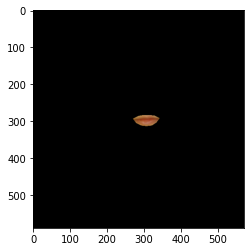

In [49]:
def lip_part(image,points,alpha=1):
    overlay = image.copy()
    output = image.copy()

    hull3 = cv2.convexHull(np.array(points[59:77]))
    cv2.drawContours(overlay, [hull3.astype(int)], -1, (0,0,0), -1)

    cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

    return output

def lip_extraction(img,points):
  img_r,img_g,img_b = cv2.split(img)
  
  output_r = lip_part(img_r,points)
  output_g = lip_part(img_g,points)
  output_b = lip_part(img_b,points)

  output = cv2.merge((output_r,output_g,output_b))
  return img - output

ref_lip = lip_extraction(a_disp,points2)
tar_lip = lip_extraction(target_color,points2)

plt.imshow(tar_lip)

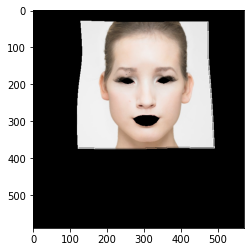

In [50]:
ref_w_lip = cv2.cvtColor(eye_lip_extraction(a_disp,points2),cv2.COLOR_RGB2BGR)

plt.imshow(ref_w_lip)

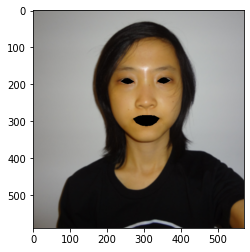

In [51]:
tar_w_lip = cv2.cvtColor(eye_lip_extraction(target_color,points2), cv2.COLOR_RGB2BGR)

plt.imshow(tar_w_lip)

In [52]:
def visualize_face(img,points):
    output = np.zeros(img.shape).astype(img.dtype)
    ans = np.zeros(img.shape).astype(img.dtype)

    hull = cv2.convexHull(np.array(points[0:16]))
    color = [255,255,255]
    cv2.fillPoly(output,[hull.astype(int)],color)
    ans = cv2.bitwise_and(img,output)

    return ans

In [53]:
def face_extraction(img,points):
  img_r,img_g,img_b = cv2.split(img)
  
  output_r = visualize_face(img_r,points)
  output_g = visualize_face(img_g,points)
  output_b = visualize_face(img_b,points)

  output = cv2.merge((output_r,output_g,output_b))
  return output

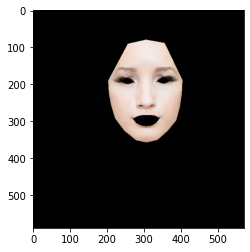

In [54]:
output = face_extraction(ref_w_lip,points2)

plt.imshow(output)

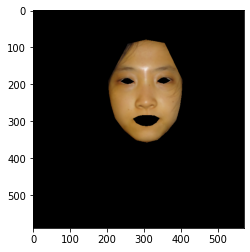

In [55]:
output2 = face_extraction(tar_w_lip,points2)

plt.imshow(output2)

(589, 570)


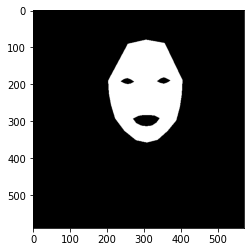

In [56]:
h,w,c = output2.shape
binary_mask = np.ones((h,w))

output2_r,output2_g,output2_b = cv2.split(output2)

mask_r = np.where(output2_r!=0,1,0)
mask_g = np.where(output2_g!=0,1,0)
mask_b = np.where(output2_b!=0,1,0)
binary_mask1 = np.bitwise_or(np.array(mask_r),np.array(mask_g))
binary_mask = np.bitwise_or(np.array(binary_mask1),np.array(mask_b))

print(binary_mask.shape)

plt.imshow(binary_mask*255,cmap='gray')

In [57]:
def linear_scaling(img,fr,fg,fb):
  r,g,b = cv2.split(img)
  r_scale = r * fr
  g_scale = g * fg
  b_scale = b * fb
  img_r = cv2.merge((r_scale,g_scale,b_scale))
  return img_r

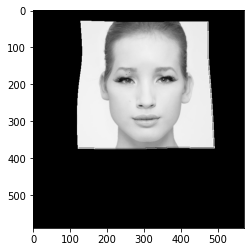

In [58]:
ref_lab = cv2.cvtColor(a_disp, cv2.COLOR_RGB2LAB)
target_lab = cv2.cvtColor(output2, cv2.COLOR_BGR2LAB)

lightness_layer = ref_lab[..., 0]
Ic_A = ref_lab[..., 1]
Ic_B = ref_lab[..., 2]

lightness_layer2 = target_lab[..., 0]
Ec_A = target_lab[..., 1]
Ec_B = target_lab[..., 2]

plt.imshow(cv2.cvtColor(lightness_layer,cv2.COLOR_BGR2RGB))

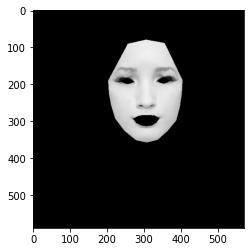

In [59]:
ref_lab = cv2.cvtColor(output, cv2.COLOR_RGB2LAB)
target_lab = cv2.cvtColor(output2, cv2.COLOR_RGB2LAB)

lightness_layer = ref_lab[..., 0]
Ic_A = ref_lab[..., 1]
Ic_B = ref_lab[..., 2]

lightness_layer2 = target_lab[..., 0]
Ec_A = target_lab[..., 1]
Ec_B = target_lab[..., 2]

plt.imshow(cv2.cvtColor(lightness_layer,cv2.COLOR_BGR2RGB))

In [60]:
def WLS_Filter(image_orig, alpha=1.2 ,lambda_= 1):
    from scipy.sparse import spdiags
    from scipy.sparse.linalg import spsolve
    eps = np.spacing(1)
    L = np.log(image_orig + eps)
    m, n = image_orig.shape
    k = m * n
    smallNum = 0.0001
    dy = np.diff(L, axis = 0)
    dy = - lambda_ / (np.power(np.abs(dy), alpha) + smallNum)
    dy = np.pad(dy, [(0, 1), (0, 0)], mode='constant')
    dy = dy.flatten(order='F')
    
    dx = np.diff(L, axis = 1)
    dx = - lambda_ / (np.power(np.abs(dx), alpha) + smallNum)
    dx = np.pad(dx, [(0, 0), (0, 1)], mode='constant')
    dx = dx.flatten(order='F')
    B = np.vstack((dx, dy))
    
    
    d = [-m, -1]
    
    a = spdiags(B, d, k, k)
    e = dx.copy()
    w = np.roll(dx, m)
    s = dy.copy()
    q = np.roll(dy, 1)
    
    D = 1 - (e + w + s + q)
    
    a = a + a.T + spdiags(D, 0, k, k)
    outp = spsolve(a, image_orig.flatten(order='F'))
    
    outp = outp.reshape((m, n), order = 'F')
    base = np.clip(outp, 0, 255)
    detail = np.clip(image_orig - base, 0, 255)
    return base, detail
    
    

In [61]:
base, detail = WLS_Filter(lightness_layer)

Text(0.5, -0.1, 'Detail Layer')

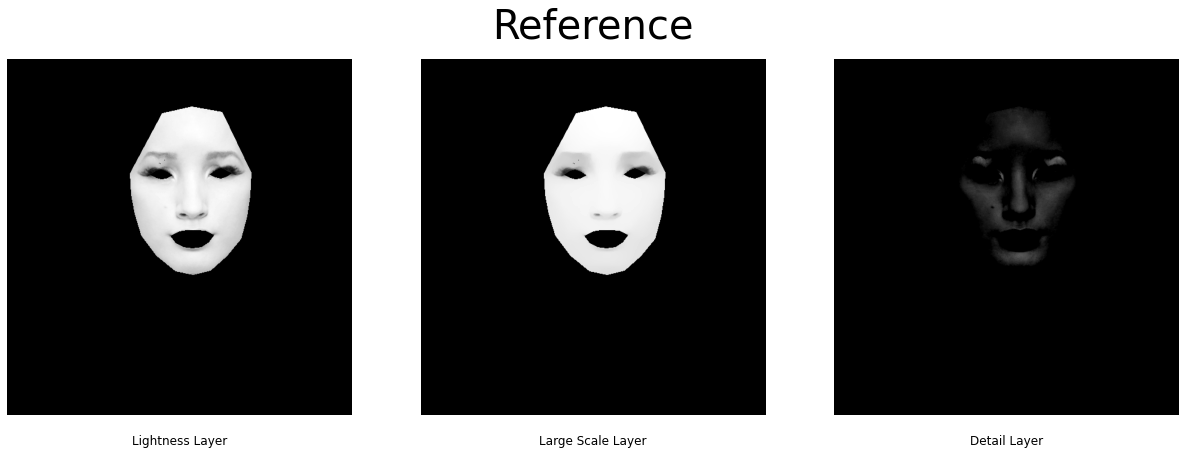

In [62]:
fig = plt.figure(figsize=(21, 7))
plt.title("Reference", fontsize = 40)
plt.axis('off')

fig.add_subplot(1, 3, 1)
plt.imshow(lightness_layer, cmap="gray")
plt.axis('off')
plt.title("Lightness Layer", y = -0.1)

fig.add_subplot(1, 3, 2)
plt.imshow(base * 4, cmap="gray")
# The paper lists that color and detail layers are multiplied by a factor of four to enhance the image
plt.axis('off')
plt.title("Large Scale Layer", y = -0.1)

fig.add_subplot(1, 3, 3)
plt.imshow(detail * 4, cmap="gray", vmin = 0 , vmax = 255)
plt.axis('off')
plt.title("Detail Layer", y = -0.1)

In [63]:
base_target, detail_target = WLS_Filter(lightness_layer2)

Text(0.5, -0.1, 'Detail Layer')

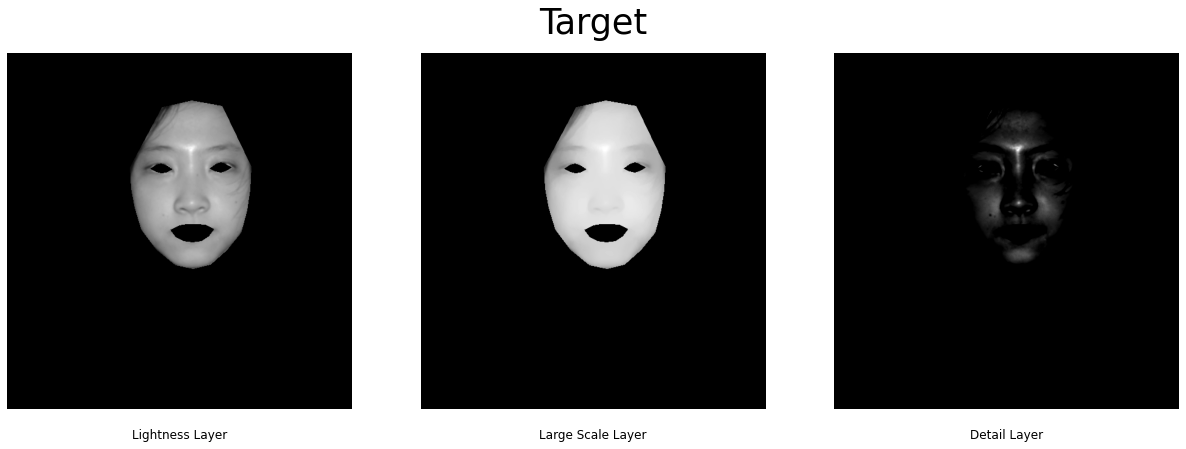

In [64]:
fig = plt.figure(figsize=(21, 7))
# plt.imshow(a.astype(np.uint8), cmap="gray")
plt.title("Target", fontsize = 35)
plt.axis('off')

fig.add_subplot(1, 3, 1)
plt.imshow(lightness_layer2, cmap="gray")
plt.axis('off')
plt.title("Lightness Layer", y = -0.1)

fig.add_subplot(1, 3, 2)
plt.imshow(base_target * 4, cmap="gray")
# The paper lists that color and detail layers are multiplied by a factor of four to enhance the image
plt.axis('off')
plt.title("Large Scale Layer", y = -0.1)

fig.add_subplot(1, 3, 3)
plt.imshow(detail_target * 4, cmap="gray", vmin = 0 , vmax = 255)
plt.axis('off')
plt.title("Detail Layer", y = -0.1)

In [65]:
def PointInsideTriangle2(pt,poly):
    hull = cv2.convexHull(np.array(poly))
    dist = cv2.pointPolygonTest(hull,(pt[0], pt[1]),False)
    if dist>=0:
        return True
    else:
        return False

def cpartition(points1, size0, size1):

    cmat = np.zeros((size0,size1))

    left_eye = points1[30:38] 
    right_eye = points1[40:48]
    mouth = points1[66:72]
    lips = points1[59:66] + points1[72:77]
    skin = points1[0:16]
    
    for y in range(size0):
        for x in range(size1):
            if PointInsideTriangle2((x,y),skin):
                if PointInsideTriangle2((x,y),left_eye):
                    cmat[y][x] = 3
                elif PointInsideTriangle2((x,y),right_eye):
                    cmat[y][x] = 3
                elif PointInsideTriangle2((x,y),lips):
                    cmat[y][x] = 2
                else:
                    cmat[y][x] = 1
    return cmat

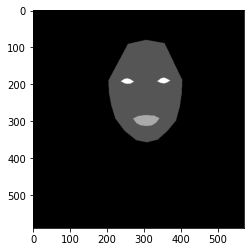

In [66]:
size = ref_lab.shape
cmat = cpartition(points2,size[0],size[1])

plt.imshow(cmat*85,cmap='gray')

In [67]:
ref_lip_Lab=cv2.cvtColor(ref_lip, cv2.COLOR_RGB2LAB)
ref_lip_L=ref_lip_Lab[:,:,0]
ref_lip_a=ref_lip_Lab[:,:,1]
ref_lip_b=ref_lip_Lab[:,:,2]

tar_lip_Lab=cv2.cvtColor(tar_lip, cv2.COLOR_RGB2LAB)
tar_lip_L=tar_lip_Lab[:,:,0]
tar_lip_a=tar_lip_Lab[:,:,1]
tar_lip_b=tar_lip_Lab[:,:,2]

ref_lip_base, ref_lip_detail = WLS_Filter(ref_lip_L)
tar_lip_base, tar_lip_detail = WLS_Filter(tar_lip_L)

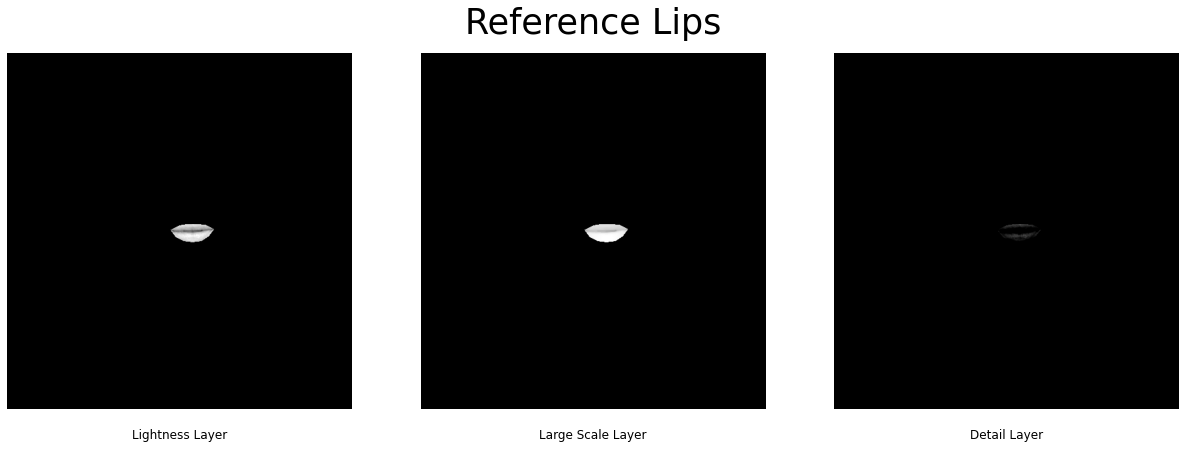

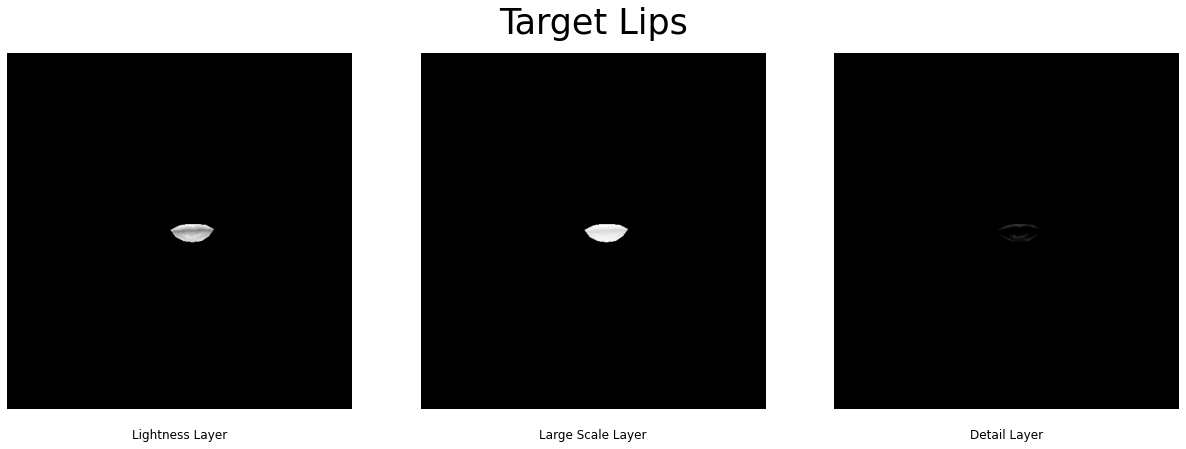

In [68]:
fig = plt.figure(figsize=(21, 7))
# plt.imshow(a.astype(np.uint8), cmap="gray")
plt.title("Reference Lips", fontsize = 35)
plt.axis('off')

fig.add_subplot(1, 3, 1)
plt.imshow(ref_lip_L, cmap="gray")
plt.axis('off')
plt.title("Lightness Layer", y = -0.1)

fig.add_subplot(1, 3, 2)
plt.imshow(ref_lip_base * 4, cmap="gray")
# The paper lists that color and detail layers are multiplied by a factor of four to enhance the image
plt.axis('off')
plt.title("Large Scale Layer", y = -0.1)

fig.add_subplot(1, 3, 3)
plt.imshow(ref_lip_detail * 2, cmap="gray", vmin = 0 , vmax = 255)
plt.axis('off')
plt.title("Detail Layer", y = -0.1)
plt.show()

fig = plt.figure(figsize=(21, 7))
# plt.imshow(a.astype(np.uint8), cmap="gray")
plt.title("Target Lips", fontsize = 35)
plt.axis('off')

fig.add_subplot(1, 3, 1)
plt.imshow(tar_lip_L, cmap="gray")
plt.axis('off')
plt.title("Lightness Layer", y = -0.1)

fig.add_subplot(1, 3, 2)
plt.imshow(tar_lip_base * 4, cmap="gray")
# The paper lists that color and detail layers are multiplied by a factor of four to enhance the image
plt.axis('off')
plt.title("Large Scale Layer", y = -0.1)

fig.add_subplot(1, 3, 3)
plt.imshow(tar_lip_detail * 2, cmap="gray", vmin = 0 , vmax = 255)
plt.axis('off')
plt.title("Detail Layer", y = -0.1)
plt.show()

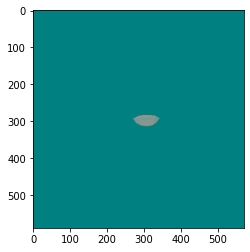

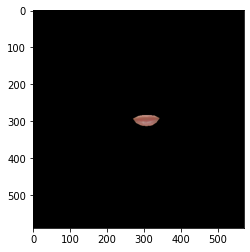

In [69]:
#Lip makeup
wt=1
we=0.5
lip_detail = wt*tar_lip_detail +we*ref_lip_detail

alpha = 0.8
lip_a = 0.8*ref_lip_a + 0.2*tar_lip_a 
lip_b = 0.8*ref_lip_b + 0.2*tar_lip_b

a,b,k=target_color.shape
lip_Lab=np.zeros((a,b,k))
lip_Lab[...,0]=lip_detail+tar_lip_base
lip_Lab[...,1]=lip_a
lip_Lab[...,2]=lip_b

lip_Lab=np.uint8(lip_Lab)
lip_rgb=cv2.cvtColor(lip_Lab,cv2.COLOR_LAB2RGB)

plt.imshow(lip_Lab,cmap='gray')
plt.show()
plt.imshow(lip_rgb)
plt.show()

In [70]:
from scipy import signal

def boundary_test(temp,i,j,h,w):
    
    if ((i-1>=0) and (i+1<h) and (j-1>=0) and (j+1<w)):
        c=2
        if (temp[i,j]==1):
            if (temp[i+1,j]==0):c=1
            elif (temp[i-1,j]==0):c=1
            elif (temp[i,j+1]==0):c=1
            elif (temp[i,j-1]==0):c=1
        else:
            c=0
    else:c=0
    return c

In [71]:
def Result_large_layer(s_l,t_l,binary_mask):
    
    #croping
    co=np.argwhere(binary_mask==1)
    min_r=np.min(co[:,0])
    min_c=np.min(co[:,1])
    max_r=np.max(co[:,0])
    max_c=np.max(co[:,1])
    r=max_r-min_r+1+2
    c=max_c-min_c+1+2
    temp_s=s_l[min_r-1:max_r+2,min_c-1:max_c+2]
    temp_t=t_l[min_r-1:max_r+2,min_c-1:max_c+2]
    temp_b=binary_mask[min_r-1:max_r+2,min_c-1:max_c+2]
    
    #getting boundary
    h,w = temp_b.shape
    boundary_filter=np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            if (boundary_test(temp_b,i,j,h,w)==1):
                boundary_filter[i,j]=1
    
    #getting boundary of target
    boundary=np.zeros((h,w))
    boundary=(temp_t*boundary_filter)
    
    #gradient calculation
    gradience_filter=np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])

    target_gradience=np.zeros((h,w))
    target_gradience=signal.convolve2d(temp_t, gradience_filter,mode='same')
    target_gradience=target_gradience*(temp_b-boundary_filter)

    source_gradience=np.zeros((h,w))
    source_gradience=signal.convolve2d(temp_s, gradience_filter,mode='same')
    source_gradience=source_gradience*(temp_b-boundary_filter)
    
    #mixing gradient
    mix_gradience=np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            if (np.abs(source_gradience[i,j])>=np.abs(target_gradience[i,j])):
                mix_gradience[i,j]=source_gradience[i,j]
            else :
                mix_gradience[i,j]=target_gradience[i,j]
    
    #Gauss Seidal calculation

    result_old=np.double(boundary)

    no_boundary=temp_b-boundary_filter

    for i in range(5000):
        for j in range(h):
            for k in range(w):
                if (no_boundary[j,k]==1):
                    result_old[j,k]=(1/4)*(mix_gradience[j,k]+result_old[j-1,k]+result_old[j+1,k]+result_old[j,k-1]+result_old[j,k+1])
                    
    #broadcasting the image
    result=np.copy(t_l)
    result[min_r-1:max_r+2,min_c-1:max_c+2]=result_old
    result=np.abs(result)
    return result

In [72]:
R_l=Result_large_layer(base,base_target,binary_mask)

Text(0.5, -0.1, 'Resultant Large Layer')

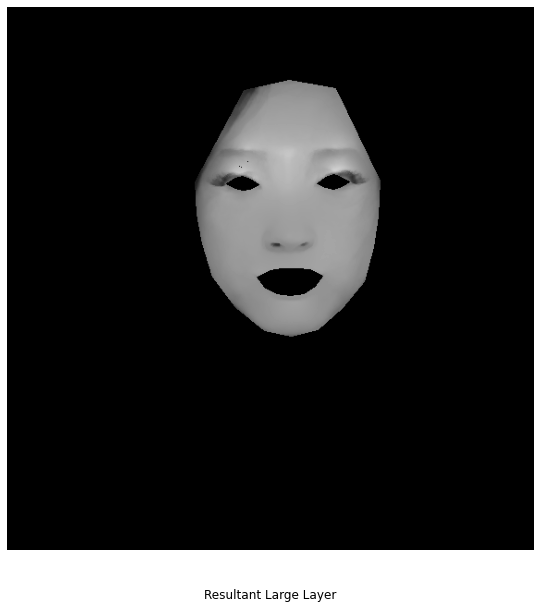

In [73]:
plt.figure(figsize=(10, 10))
plt.imshow(R_l, cmap="gray", vmin = 0 , vmax = 255)
plt.axis('off')
plt.title("Resultant Large Layer", y = -0.1)

In [90]:

def alphaBlending(img0, img1, alpha, reqsize=False):
  '''
  images are in L,a,b
  img1 is reference 
  If image sizes are not equal:
  if reqsize=False: resize both imges to size of img0
              else: resize them to size of img1
  '''
  if (img0.shape!=img1.shape):
    if reqsize:
      a,b=img1.shape
    else:
      a,b=img0.shape
    img0=cv2.resize(img0,(b,a))
    img1=cv2.resize(img1,(b,a))

  img1=img1.astype('float32')
  img0=img0.astype('float32')

  out=alpha*img0 + (1-alpha)*img1
  # out=img0 + alpha*(img1-img0)
  return out



In [91]:
def weightedSum(wt,imgt,we,imge):
  '''
  Attributes:
  wt,imgt is weight and image array itself of target image.
  we,imge is that of reference image. @mana
  '''
  imgt=imgt.astype('float32')
  imge=imge.astype('float32')

  out=wt*imgt + we*imge
  return out

In [92]:
import skimage
import skimage.data
import skimage.morphology
import skimage.filters

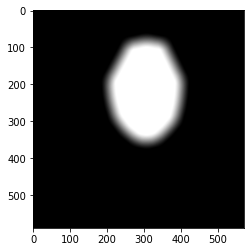

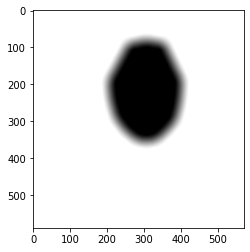

In [93]:


binary = (cmat >0).astype('float32')

# create disk-like filter footprint with given radius
radius = 20
circle = skimage.morphology.disk(radius)

# apply median filter with given footprint = structuring element = selem
f = cv2.filter2D(binary,-1,circle)
f=np.abs(f)
f/=f.max()
plt.imshow(f,cmap='gray')
plt.show()

plt.imshow(1-f,cmap='gray')
plt.show()

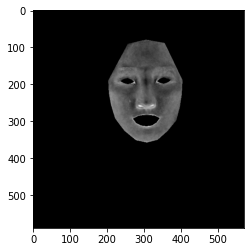

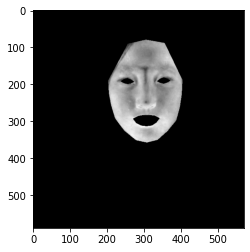

In [94]:
alpha=0.6
Rc_a=alphaBlending(Ic_A,Ec_A,alpha)
Rc_b=alphaBlending(Ic_B,Ec_B,alpha)
plt.imshow(Rc_a,cmap='gray')
plt.show()
plt.imshow(Rc_b,cmap='gray')
plt.show()

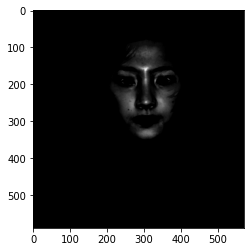

In [95]:
wt=1
we=0.5
R_d = weightedSum(wt,detail_target,we,detail)
plt.imshow(R_d,cmap='gray')
plt.show()

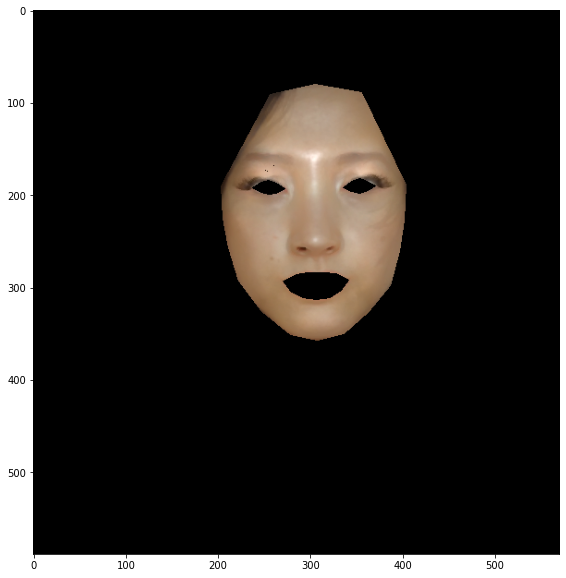

In [96]:
h,w=detail_target.shape
ans_lab=np.zeros((h,w,3))
R_s = R_d+R_l
R_s/=R_s.max()
R_s*=255
ans_lab[:,:,0]=(R_s)
# ans_lab[...,0]/=(ans_lab[...,0].max())/100
ans_lab[...,0]=(ans_lab[...,0].astype('int32'))
ans_lab[...,1]=(Rc_a.astype('int32'))
ans_lab[...,2]=(Rc_b.astype('int32'))
ans_lab=np.uint8(ans_lab)
ans_lab = np.clip(ans_lab, 0, 255)
R_sum = cv2.cvtColor(ans_lab, cv2.COLOR_LAB2RGB)
plt.figure(figsize=(10,10))
plt.imshow(R_sum)

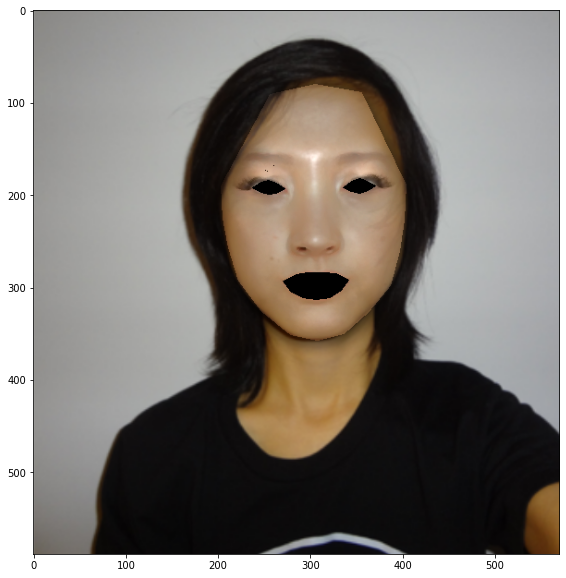

In [97]:
ans=np.zeros((a,b,k),dtype='float32')
ans[...,0]=((1-f)*target_color[...,0]+ f*R_sum[...,0])
ans[...,1]=((1-f)*target_color[...,1]+ f*R_sum[...,1])
ans[...,2]=((1-f)*target_color[...,2]+ f*R_sum[...,2])
ans=np.uint8(ans)
plt.figure(figsize=(10,10))
plt.imshow(ans)

<Figure size 720x720 with 0 Axes>

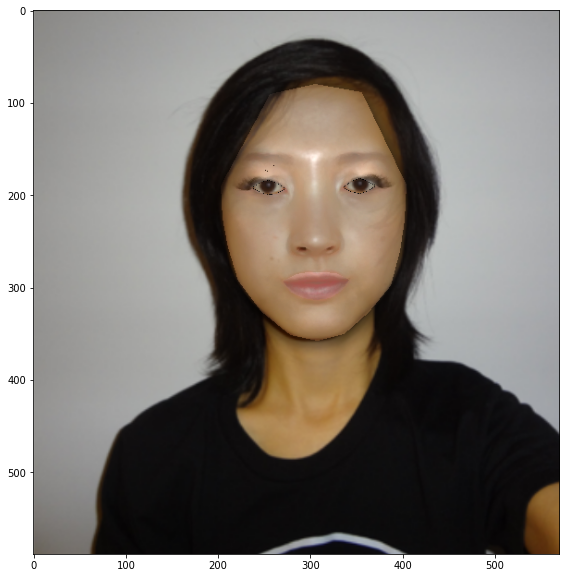

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [98]:
ans=np.zeros((a,b,k),dtype='float32')
ans[...,0]=((1-f)*target_color[...,0]+ f*R_sum[...,0])
ans[...,1]=((1-f)*target_color[...,1]+ f*R_sum[...,1])
ans[...,2]=((1-f)*target_color[...,2]+ f*R_sum[...,2])
ans=np.uint8(ans)
plt.figure(figsize=(10,10))
# plt.imshow(ans)
# plt.show()

lip_mask=(cmat==2).astype('float32')
radius = 2
circle = skimage.morphology.disk(radius)
lip_mask = cv2.filter2D(lip_mask,-1,circle)
lip_mask=np.abs(lip_mask)
lip_mask/=lip_mask.max()
ans[...,0]+=np.uint8(f*lip_rgb[...,0])
ans[...,1]+=np.uint8(f*lip_rgb[...,1])
ans[...,2]+=np.uint8(f*lip_rgb[...,2])

eye_mask=(cmat==3).astype('float32')
ans[...,0]+=np.uint8(eye_mask*target_color[...,0])
ans[...,1]+=np.uint8(eye_mask*target_color[...,1])
ans[...,2]+=np.uint8(eye_mask*target_color[...,2])
plt.figure(figsize=(10,10))
plt.imshow(ans)
plt.show()
plt.figure(figsize=(10,10))